# Combination of fits of different models

In [1]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
# from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.hidden_markov_model import PoissonHMM

from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files, prepro_design_matrix, concatenate_sessions, fix_discontinuities
from fitting_functions import cross_validate_armodel, compute_inputs

functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from postprocessing_functions import best__kappa, best_lag_kappa

one = ONE(mode='remote')

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Parameters

In [2]:
bin_size = 0.1
bin_size = 0.02

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

data_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v4_5Jul2024/' + str(bin_size) + '/'

In [3]:
# Load preprocessed data
prepro_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'
os.chdir(prepro_results_path)
idxs, mouse_names, matrix_all, matrix_all_unnorm, session_all = pickle.load(open(prepro_results_path + "preprocessed_data_v4_170724", "rb"))
collapsed_matrices, collapsed_unnorm, collapsed_trials = concatenate_sessions (mouse_names, matrix_all, matrix_all_unnorm, session_all)


## Parameters

In [4]:
num_iters = 100
num_train_batches = 5
method = 'kmeans'
threshold = 0.05

num_lags = 11  # First order ARHMM
num_states = 2
kappa = 1000

# Values for grid search (should get this from results)
last_lag = 20
lag_step = 2
start_lag = 1
Lags = list(range(start_lag, last_lag, lag_step))
kappas = [0, 1, 5, 10, 100, 500, 1000, 2000, 5000, 7000, 10000]

use_sets = [['avg_wheel_vel'], ['Lick count'], ['whisker_me'],
            ['left_X', 'left_Y', 'right_X', 'right_Y'], ['nose_X', 'nose_Y']]
var_interest_map = ['avg_wheel_vel', 'Lick count', 'whisker_me', 'left_X', 'nose_X']
idx_init_list = [0, 1, 2, 3, 7]
idx_end_list = [1, 2, 3, 7, 9]

## Fit sessions with params from best fit for all variable sets (models)

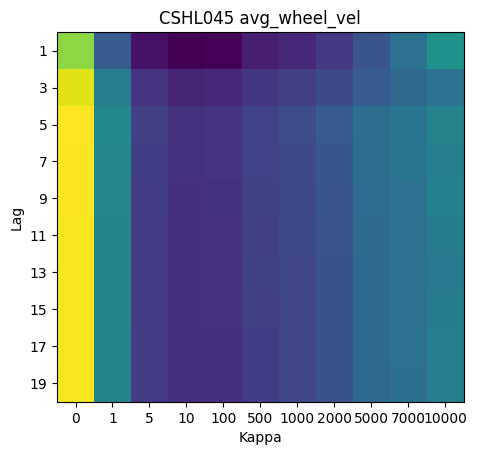

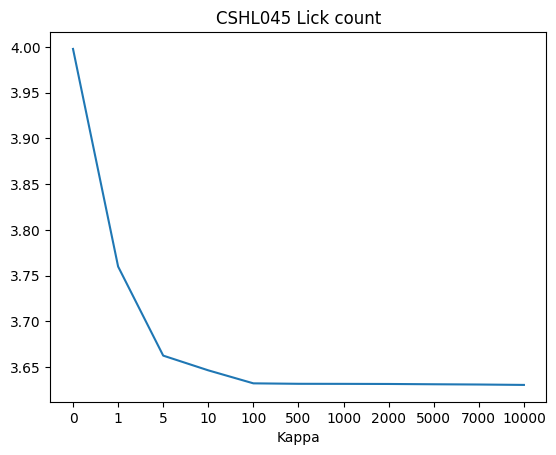

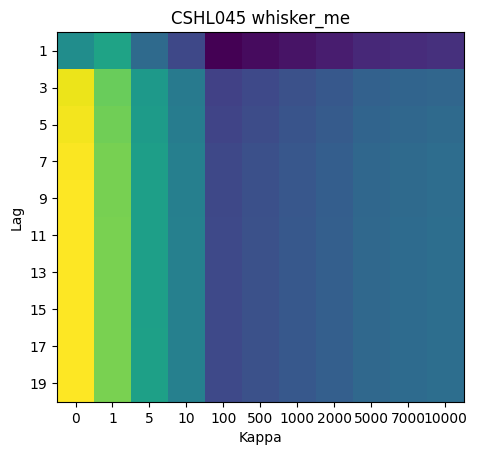

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN axis encountered
  return f_raw(*args, **kwargs)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [5]:
for s, var_interest in enumerate(var_interest_map):
        
    index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
    idx_init = idx_init_list[index_var]
    idx_end = idx_end_list[index_var]
    var_names = use_sets[index_var]
    
    # Loop through animals
    for m, mouse_name in enumerate(mouse_names[0:1]):

            # Get mouse data
            design_matrix = collapsed_matrices[mouse_name][:,idx_init:idx_end]

            # if len(np.shape(design_matrix)) > 2:
            #     design_matrix = design_matrix[0]
            
            # Get results from grid search
            results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/grid_search'
            os.chdir(results_path)
            all_lls, all_baseline_lls, all_init_params, all_fit_params = pickle.load(open("best_results_" + var_names[0] + '_' + mouse_name, "rb"))
    
            # Prepare data 
            num_timesteps = np.shape(design_matrix)[0]
            emission_dim = np.shape(design_matrix)[1]
            shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
            train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
            
            # Retrieve best fits
            if 'Lick count' in var_names:
                best_kappa, mean_bits_LL, best_fold = best__kappa(all_lls, all_baseline_lls, design_matrix, num_train_batches, kappas)
                index_kappa = np.where(np.array(kappas)==best_kappa)[0][0]
                use_fold = int(best_fold[index_kappa])
                
                " Fit model with best params"
        
                best_params = all_fit_params[best_kappa]
                
                # Find parameters for best fold
                initial_probs = best_params[0].probs[use_fold]
                transition_matrix = best_params[1].transition_matrix[use_fold]
                emission_rates = best_params[2].rates[use_fold]      
                
                # Initialize new hmm
                test_phmm = PoissonHMM(num_states, emission_dim, transition_matrix_stickiness=best_kappa)
                best_fold_params, props = test_phmm.initialize(key=jr.PRNGKey(0), method=method,
                                                initial_probs=initial_probs,
                                                transition_matrix=transition_matrix,               
                                                emission_rates=emission_rates)  # not sure if I need to include  
                
                # Get state estimates for validation data
                most_likely_states = test_phmm.most_likely_states(best_fold_params, shortened_array)
                
                # Plot grid search
                plt.plot(mean_bits_LL)
                plt.xlabel('Kappa')
                plt.xticks(np.arange(0, len(kappas), 1), kappas)
                plt.title(mouse_name + ' ' + var_interest)
                plt.show()
            else:
                best_lag, best_kappa, mean_bits_LL, best_fold = best_lag_kappa(all_lls, all_baseline_lls, design_matrix, num_train_batches, kappas, Lags)
                index_lag = np.where(np.array(Lags)==best_lag)[0][0]
                index_kappa = np.where(np.array(kappas)==best_kappa)[0][0]
                use_fold = int(best_fold[index_lag, index_kappa])
            
                " Fit model with best params"
                # Compute inputs for required timelags
                my_inputs = compute_inputs(shortened_array, best_lag, emission_dim)
                train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))
                
                best_params = all_fit_params[best_lag][best_kappa]
                
                # Find parameters for best fold
                initial_probs = best_params[0].probs[use_fold]
                transition_matrix = best_params[1].transition_matrix[use_fold]
                emission_weights = best_params[2].weights[use_fold]
                emission_biases = best_params[2].biases[use_fold]
                emission_covariances = best_params[2].covs[use_fold]        
                
                # Initialize new hmm
                new_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=best_lag, transition_matrix_stickiness=best_kappa)
                best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                                initial_probs=initial_probs,
                                                transition_matrix=transition_matrix,               
                                                emission_weights=emission_weights,
                                                emission_biases=emission_biases, 
                                                emission_covariances=emission_covariances,
                                                emissions=shortened_array)  # not sure if I need to include  
                
                # Get state estimates for validation data
                most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array, my_inputs)
                            
                # Plot grid search
                plt.imshow(mean_bits_LL)
                plt.xticks(np.arange(0, len(kappas), 1), kappas)
                plt.yticks(np.arange(0, len(Lags), 1), Lags)
                plt.xlabel('Kappa')
                plt.ylabel('Lag')
                plt.title(mouse_name + ' ' + var_interest)
                plt.show()
            
            to_save = most_likely_states, use_fold

            # Save most_likely_states
            states_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/most_likely_states'
            os.chdir(states_results_path)
            pickle.dump(to_save, open("most_likely_states" + var_names[0] + '_' + mouse_name , "wb"))   